In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data_path = "./ex_all.csv"
custom_palette = {
    "ER": "#1f77b4",      # Blue color
    "BER": "#ff7f0e",     # Orange color
    "PER": "#2ca02c",     # Green color
    "PBER": "#d62728"     # Red color
}

/tmp/ipykernel_10700/3273636668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time(h)"] = data["time_total_s"] / 3600
/tmp/ipykernel_10700/3273636668.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["time(h)"] // window_size) * window_size
/tmp/ipykernel_10700/3273636668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

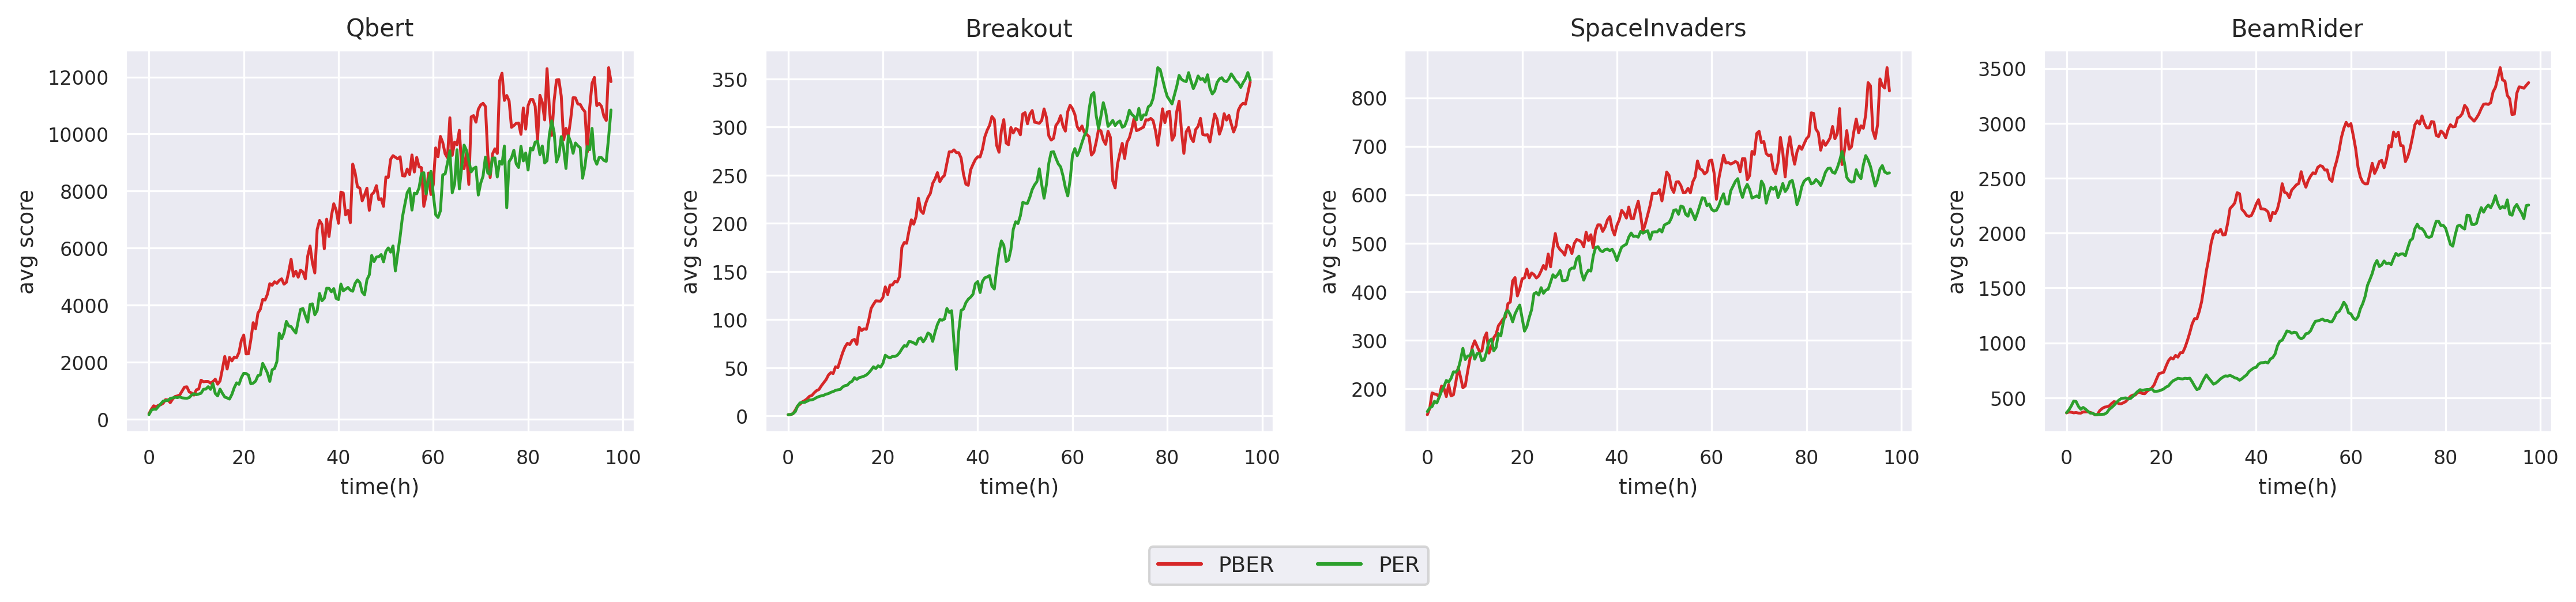

In [13]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["buffer"].isin(["PER", "PBER"])]
# Filter the environments
data_df["time(h)"] = data_df["time_total_s"] / 3600
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 1

def compute_rolling_mean(data, window_size=0.5):
    data["time(h)"] = data["time_total_s"] / 3600
    data["time_group"] = (data["time(h)"] // window_size) * window_size
    smoothed_data = data.groupby(["time_group", "buffer"])["episode_reward_mean"].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

fig, axes = plt.subplots(1, 4, figsize=(15, 3), dpi=300)
axes = axes.reshape(-1)
all_lines = []
all_labels = []

for ax_n, (env, data) in enumerate(smoothed_sampler.items()):
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=data.iloc[:-10], ax=axes[ax_n], palette=custom_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("time(h)", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Collect legend data for each subplot
    handles, labels = ax.get_legend_handles_labels()
    all_lines.extend(handles)
    all_labels.extend(labels)
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Create a unique set of legend labels and their corresponding lines
unique_labels, unique_lines = zip(*dict(zip(all_labels, all_lines)).items())
fig.legend(unique_lines, unique_labels, loc="upper center", bbox_to_anchor=(0.5,-0.05), ncol=len(unique_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.15)
plt.savefig("./images/experiments/rl_e_er_by_time.png")
plt.show()

/tmp/ipykernel_10700/1298801114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["num_env_steps_sampled"] // window_size) * window_size
/tmp/ipykernel_10700/1298801114.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = data["time_group"] * 4
/tmp/ipykernel_10700/1298801114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

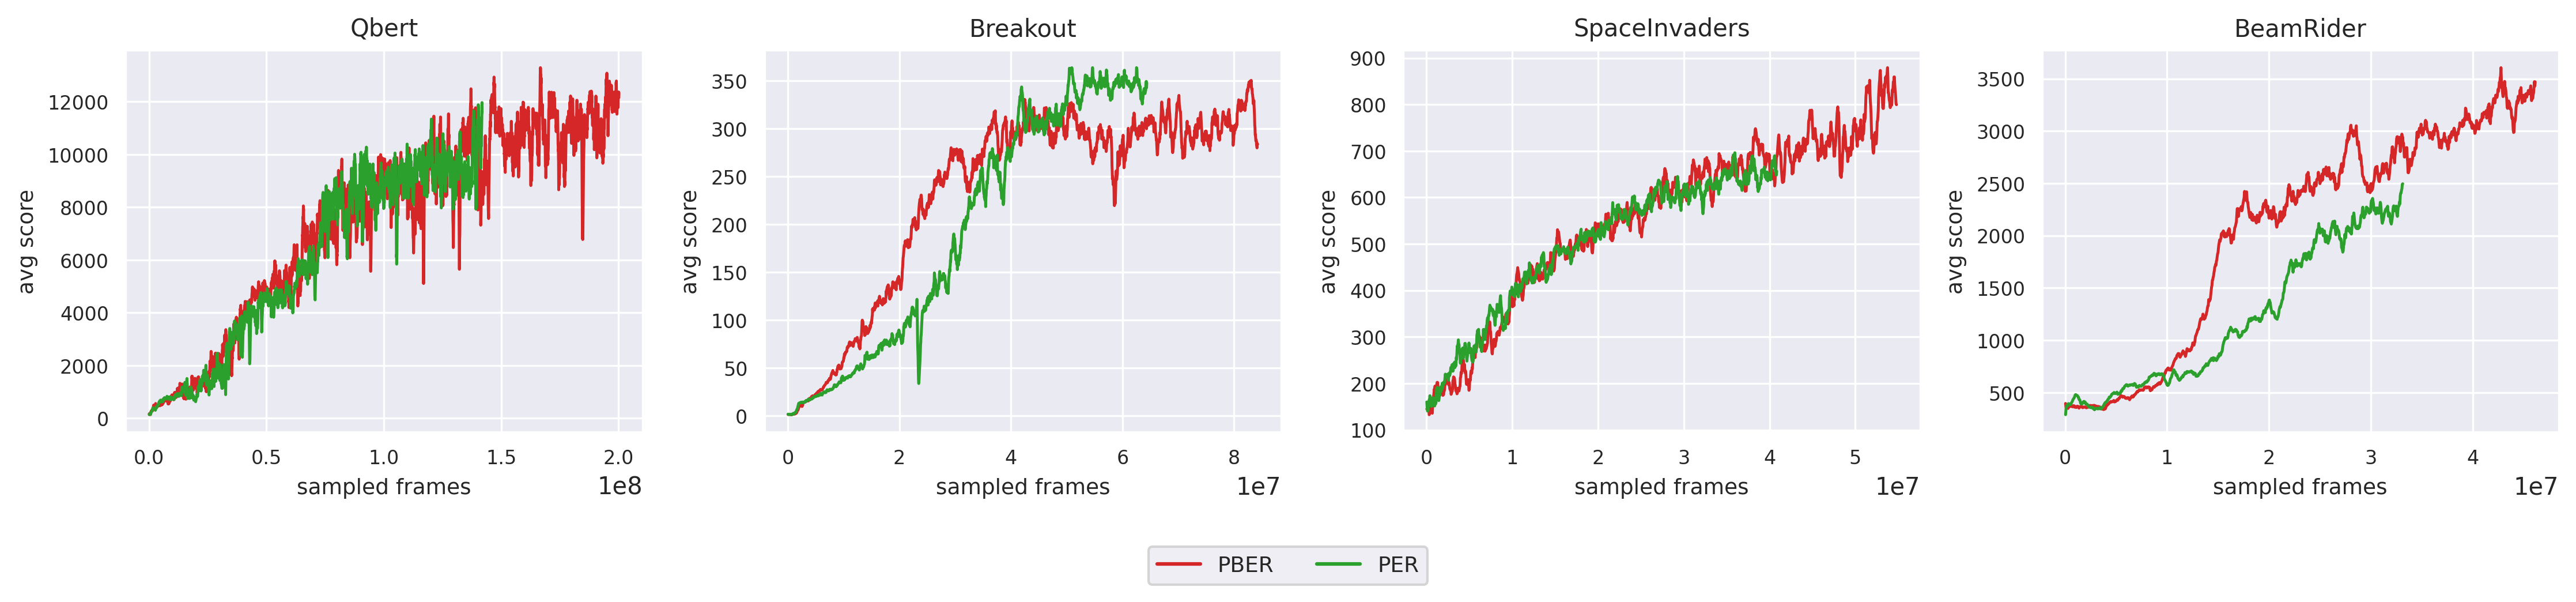

In [17]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["buffer"].isin(["PER", "PBER"])]
# Filter the environments
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 50000

def compute_rolling_mean(data, window_size=0.5):
    data["time_group"] = (data["num_env_steps_sampled"] // window_size) * window_size
    data["time_group"] = data["time_group"] * 4
    smoothed_data = data.groupby(["time_group", "buffer"])[["episode_reward_mean"]].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

fig, axes = plt.subplots(1, 4, figsize=(15, 3), dpi=300)
axes = axes.reshape(-1)
all_lines = []
all_labels = []

for ax_n, (env, data) in enumerate(smoothed_sampler.items()):
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=data.iloc[:-10], ax=axes[ax_n], palette=custom_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("sampled frames", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Collect legend data for each subplot
    handles, labels = ax.get_legend_handles_labels()
    all_lines.extend(handles)
    all_labels.extend(labels)
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Create a unique set of legend labels and their corresponding lines
unique_labels, unique_lines = zip(*dict(zip(all_labels, all_lines)).items())
fig.legend(unique_lines, unique_labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(unique_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.15)
plt.savefig("./images/analysis/rl_e_er_by_frames.png")
plt.show()

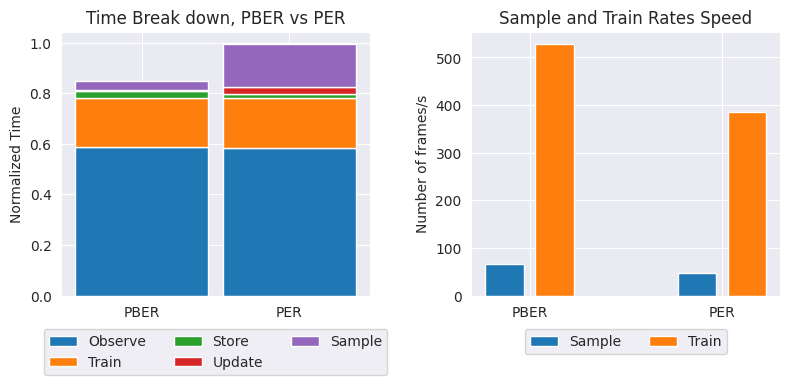

In [7]:
# Load the data

colors = {
    "observe": "#1f77b4",
    "train": "#ff7f0e",
    "store": "#2ca02c",
    "update": "#d62728",
    "sample": "#9467bd"
}

data_df = pd.read_csv(data_path)
data_df = data_df[data_df["buffer"].isin(['PER', 'PBER'])]
filtered_data_df = data_df.copy()
filtered_data_df = filtered_data_df[filtered_data_df["num_env_steps_sampled"] <= 400000]
filtered_data_df["observe"] = filtered_data_df["all"] - filtered_data_df[["store", "sample", "train", "update"]].sum(axis=1)
# First, ensure that all the columns we're working with are of the correct data type.
min_max_sampled_per_pber = filtered_data_df[filtered_data_df['buffer'].isin(['PER', 'PBER'])].groupby(['env', 'buffer'])['num_env_steps_sampled'].max().unstack().min(axis=1)

filtered_data_df = filtered_data_df.merge(min_max_sampled_per_pber.reset_index(), on='env', how='left')
filtered_data_df.rename(columns={0: 'num_env_steps_sampled_min_max_for_per_pber'}, inplace=True)

filtered_data_per_pber = filtered_data_df[(filtered_data_df['num_env_steps_sampled'] <= filtered_data_df['num_env_steps_sampled_min_max_for_per_pber']) & filtered_data_df['buffer'].isin(['PBER', 'PER'])]

# Using the provided logic to create the merged_time dataframe
merged_time = []
for i, x in filtered_data_per_pber.groupby(['env', 'num_env_steps_sampled']):
    merged_time.append([i[0], i[1], x["time_total_s"].max()])
merged_time = pd.DataFrame(merged_time, columns=["env", "num_env_steps_sampled", "max_time"])

# Merging the merged_time dataframe with the filtered_data_per_pber and filtered_data_ber_er to get normalization_value
filtered_data_per_pber = filtered_data_per_pber.merge(merged_time, on=["env", "num_env_steps_sampled"], how="left")

filtered_data_per_pber.rename(columns={"max_time": "normalization_value"}, inplace=True)

# Normalize all columns including 'observe'
columns_to_normalize = ["observe", "train", "store","update", "sample", ]

for col in columns_to_normalize:
    filtered_data_per_pber[col + "_norm"] = filtered_data_per_pber[col] / filtered_data_per_pber["normalization_value"]

# Re-plotting the visualizations with corrections

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False, dpi=100)

# Left Plot: Time Break down, PBER vs PER
bottom_values_per = np.zeros(len(filtered_data_per_pber["buffer"].unique()))
legend_handles = []
for col in columns_to_normalize:
    bar_values = filtered_data_per_pber.groupby("buffer")[col + "_norm"].mean()
    bars = axes[0].bar(index_adjusted, bar_values, adjusted_bar_width, color=colors[col], bottom=bottom_values_per, label=col.capitalize())
    bottom_values_per += bar_values.values
    legend_handles.append(bars[0])

axes[0].set_title('Time Break down, PBER vs PER')
axes[0].set_xticks(index_adjusted)
axes[0].set_xticklabels(bar_values.index)
axes[0].set_ylabel('Normalized Time')
axes[0].legend(legend_handles, [col.capitalize() for col in columns_to_normalize], loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)

# Right Plot: Sample and Train Rates Speed
axes[1].bar([p - 0.13 for p in positions_B_final], mean_rates_final["sample_rate"], width=0.2, label="Sample", color="#1f77b4")
axes[1].bar([p + 0.13 for p in positions_B_final], mean_rates_final["train_rate"], width=0.2, label="Train", color="#ff7f0e")
axes[1].set_title('Sample and Train Rates Speed')
axes[1].set_ylabel('Number of frames/s')
axes[1].set_xticks(index_adjusted)
axes[1].set_xticklabels(["PBER", "PER"])
axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.show()


In [22]:
data_df = pd.read_csv(data_path)
n = 10
data_df["time(h)"] = data_df["time_total_s"] / 3600
window_size_hours = 0.25
# 2. Define helper functions

def apply_offsets_to_data(data):
    recommended_offsets = {
        'Boxing': 20,
        'Pong': 21,
        'FishingDerby': 100,
        'Frostbite': 5,
        'Enduro': 10,
        'Q*bert': 0
    }
    for env, min_reward in data.groupby('env')['episode_reward_mean'].min().items():
        if env not in recommended_offsets and min_reward < 0:
            recommended_offsets[env] = abs(min_reward) + 1
    data['episode_reward_mean_offset'] = data.apply(lambda row: row['episode_reward_mean'] + recommended_offsets.get(row['env'], 0), axis=1)
    return data

def compute_interval_mean_with_env(env_data):
    env_name = env_data['env'].iloc[0]
    bins = list(np.arange(0, env_data["time(h)"].max() + window_size_hours, window_size_hours))
    env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
    numeric_cols = env_data.select_dtypes(include=[np.number]).columns.tolist()
    interval_data = env_data.groupby('time_interval')[numeric_cols].mean().reset_index()
    interval_data['env'] = env_name
    return interval_data

def compute_avg_reward_last_episodes(env_name, data1, data2, n):
    last_rewards1 = data1[data1['env'] == env_name]['episode_reward_mean'].tail(n).values
    last_rewards2 = data2[data2['env'] == env_name]['episode_reward_mean'].tail(n).values
    avg_reward1 = last_rewards1.mean()
    avg_reward2 = last_rewards2.mean()
    return avg_reward1, avg_reward2

def compute_T_save_for_env(env_name, data1, data2):
    rewards1 = data1[data1['env'] == env_name]['episode_reward_mean'].values
    rewards2 = data2[data2['env'] == env_name]['episode_reward_mean'].values
    if len(rewards1) == 0 or len(rewards2) == 0:
        return None
    times1 = data1[data1['env'] == env_name]['time(h)'].values
    times2 = data2[data2['env'] == env_name]['time(h)'].values
    time_diff_ratios = []
    max_reward = max(rewards1.max(), rewards2.max())
    reward_samples = np.linspace(0, max_reward, 51)
    for target_reward in reward_samples:
        time1 = next((times1[i] for i, r in enumerate(rewards1) if r >= target_reward), None)
        time2 = next((times2[i] for i, r in enumerate(rewards2) if r >= target_reward), None)
        if time1 is not None and time2 is not None:
            time_diff_ratio = (time1 - time2) / time1
            time_diff_ratios.append(time_diff_ratio)
    return np.median(time_diff_ratios) if time_diff_ratios else None

# 3. Main data processing and analysis steps

# Sort data by time
data_df_sorted = data_df.sort_values(by=["env", "time(h)"])

# Split sorted data for ER vs. BER and PER vs. PBER
per_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'PER']
pber_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'PBER']

# Apply offsets to the data
data_df_sorted = apply_offsets_to_data(data_df_sorted)

# Compute interval mean for each buffer type and environment using sorted data
per_interval_data_sorted = pd.concat([compute_interval_mean_with_env(per_data_sorted[per_data_sorted['env'] == env]) for env in per_data_sorted['env'].unique()])
pber_interval_data_sorted = pd.concat([compute_interval_mean_with_env(pber_data_sorted[pber_data_sorted['env'] == env]) for env in pber_data_sorted['env'].unique()])

# Compute metrics for ER vs. BER and PER vs. PBER using sorted data
results_sorted = []
for env in data_df_sorted['env'].unique():
    R_improve_per_pber = (pber_interval_data_sorted[pber_interval_data_sorted['env'] == env]["episode_reward_mean"].median() - per_interval_data_sorted[per_interval_data_sorted['env'] == env]["episode_reward_mean"].median()) / pber_interval_data_sorted[pber_interval_data_sorted['env'] == env]["episode_reward_mean"].median()
    T_save_per_pber = compute_T_save_for_env(env, per_data_sorted, pber_data_sorted)
    avg_per_reward, avg_pber_reward = compute_avg_reward_last_episodes(env, per_data_sorted, pber_data_sorted, n)
    improvement_percentage_per_pber = ((avg_pber_reward - avg_per_reward) / avg_per_reward)  if avg_per_reward != 0 else np.nan
    
    results_sorted.append({
        'Environment': env,
        'R_improve_PER_PBER': R_improve_per_pber,
        'T_save_PER_PBER': T_save_per_pber,
        'Improvement_PER_PBER': improvement_percentage_per_pber
    })

# Convert results to a DataFrame and compute mean values
result_df_sorted = pd.DataFrame(results_sorted).set_index('Environment')
mean_values_sorted = result_df_sorted.mean(axis=0, skipna=True)
mean_values_sorted.name = "Mean"
result_df_sorted = pd.concat([result_df_sorted, pd.DataFrame(mean_values_sorted).T])

result_df_sorted

/tmp/ipykernel_10700/2621829462.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_10700/2621829462.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_10700/2621829462.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,R_improve_PER_PBER,T_save_PER_PBER,Improvement_PER_PBER
BeamRider,0.551634,0.513878,0.476032
Breakout,0.223589,0.433744,-0.178539
Qbert,0.301625,0.294004,0.080461
SpaceInvaders,0.109305,0.181701,0.173793
Mean,0.296538,0.355832,0.137937


In [20]:
# 1. Adjust for new alignment value
data_df = pd.read_csv("./ex_all.csv")
data_df["steps"] = data_df["num_env_steps_sampled"] * 4
# 1. Adjust for new alignment value
data_df["steps"] = data_df["num_env_steps_sampled"] * 4
window_size = 50000

# 2. Define helper functions

def compute_interval_mean_with_steps(env_data):
    env_name = env_data['env'].iloc[0]
    bins = list(np.arange(0, env_data["steps"].max() + window_size, window_size))
    env_data["steps_interval"] = pd.cut(env_data["steps"], bins, labels=bins[:-1], right=False)
    numeric_cols = env_data.select_dtypes(include=[np.number]).columns.tolist()
    interval_data = env_data.groupby('steps_interval')[numeric_cols].mean().reset_index()
    interval_data['env'] = env_name
    return interval_data

def compute_T_save_for_steps(env_name, data1, data2):
    rewards1 = data1[data1['env'] == env_name]['episode_reward_mean'].values
    rewards2 = data2[data2['env'] == env_name]['episode_reward_mean'].values
    steps1 = data1[data1['env'] == env_name]['steps'].values
    steps2 = data2[data2['env'] == env_name]['steps'].values
    steps_diff_ratios = []
    max_reward = max(rewards1.max(), rewards2.max())
    reward_samples = np.linspace(0, max_reward, 51)
    for target_reward in reward_samples:
        step1 = next((steps1[i] for i, r in enumerate(rewards1) if r >= target_reward), None)
        step2 = next((steps2[i] for i, r in enumerate(rewards2) if r >= target_reward), None)
        if step1 is not None and step2 is not None:
            steps_diff_ratio = (step1 - step2) / step1
            steps_diff_ratios.append(steps_diff_ratio)
    return np.median(steps_diff_ratios) if steps_diff_ratios else None


def compute_improvement_per_pber(env_name, data_per, data_pber, n):
    # Get last n steps from PER
    last_steps_per = data_per[data_per['env'] == env_name]['steps'].tail(n).values
    
    # Get rewards from PBER at the same steps
    pber_rewards_at_same_steps = []
    for step in last_steps_per:
        closest_pber_row = data_pber[data_pber['env'] == env_name].iloc[(data_pber[data_pber['env'] == env_name]['steps'] - step).abs().argsort()[:1]]
        if not closest_pber_row.empty:
            pber_rewards_at_same_steps.append(closest_pber_row['episode_reward_mean'].values[0])
    
    avg_per_reward = data_per[data_per['env'] == env_name]['episode_reward_mean'].tail(n).mean()
    avg_pber_reward_at_same_steps = np.mean(pber_rewards_at_same_steps)
    
    improvement_percentage_per_pber = ((avg_pber_reward_at_same_steps - avg_per_reward) / avg_per_reward)  if avg_per_reward != 0 else np.nan
    
    return improvement_percentage_per_pber



# 3. Main data processing and analysis steps with adjusted alignment

data_df_sorted = data_df.sort_values(by=["env", "steps"])
per_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'PER']
pber_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'PBER']

per_interval_data_sorted = pd.concat([compute_interval_mean_with_steps(per_data_sorted[per_data_sorted['env'] == env]) for env in per_data_sorted['env'].unique()])
pber_interval_data_sorted = pd.concat([compute_interval_mean_with_steps(pber_data_sorted[pber_data_sorted['env'] == env]) for env in pber_data_sorted['env'].unique()])

results_sorted_steps_adj = []
for env in data_df_sorted['env'].unique():
    R_improve_per_pber = (pber_interval_data_sorted[pber_interval_data_sorted['env'] == env]["episode_reward_mean"].median() - per_interval_data_sorted[per_interval_data_sorted['env'] == env]["episode_reward_mean"].median()) / pber_interval_data_sorted[pber_interval_data_sorted['env'] == env]["episode_reward_mean"].median()
    T_save_per_pber = compute_T_save_for_steps(env, per_data_sorted, pber_data_sorted)
    improvement_percentage_per_pber_adj = compute_improvement_per_pber(env, per_data_sorted, pber_data_sorted, n)
    
    results_sorted_steps_adj.append({
        'Environment': env,
        'R_improve_PER_PBER': R_improve_per_pber,
        'T_save_PER_PBER': T_save_per_pber,
        'Improvement_PER_PBER': improvement_percentage_per_pber_adj
    })

result_df_sorted_steps_adj = pd.DataFrame(results_sorted_steps_adj).set_index('Environment')
mean_values_sorted_steps_adj = result_df_sorted_steps_adj.mean(axis=0, skipna=True)
mean_values_sorted_steps_adj.name = "Mean"
result_df_sorted_steps_adj = pd.concat([result_df_sorted_steps_adj, pd.DataFrame(mean_values_sorted_steps_adj).T])

result_df_sorted_steps_adj

/tmp/ipykernel_10700/1001601650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["steps_interval"] = pd.cut(env_data["steps"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_10700/1001601650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["steps_interval"] = pd.cut(env_data["steps"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_10700/1001601650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,R_improve_PER_PBER,T_save_PER_PBER,Improvement_PER_PBER
BeamRider,0.554110,0.301653,0.192824
Breakout,0.263209,0.256720,-0.119315
Qbert,0.270056,0.057958,-0.212178
SpaceInvaders,0.123280,0.000000,0.020388
Mean,0.302664,0.154083,-0.029570
